# Create Synthetic Sine Wave Data

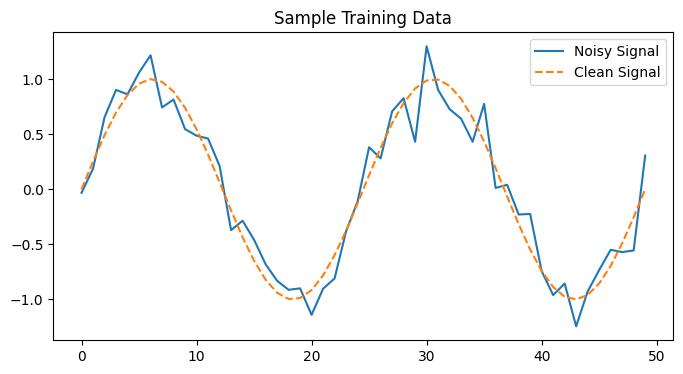

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers

# Constants
samples = 10000
timesteps = 50  # Reduced for ESP32
latent_dim = 8  # Reduced latent dimension

# Generate sine wave data
def generate_sine_wave(timesteps=50, noise_factor=0.2):
    x = np.linspace(0, 4 * np.pi, timesteps)
    clean_signal = np.sin(x)
    noisy_signal = clean_signal + noise_factor * np.random.randn(*x.shape)
    return clean_signal, noisy_signal

# Prepare dataset
X_clean, X_noisy = zip(*[generate_sine_wave(timesteps=timesteps) for _ in range(samples)])

X_clean = np.array(X_clean).reshape(samples, timesteps, 1)
X_noisy = np.array(X_noisy).reshape(samples, timesteps, 1)

# Train-validation split
split = int(0.8 * samples)
X_train, X_val = X_noisy[:split], X_noisy[split:]
Y_train, Y_val = X_clean[:split], X_clean[split:]

# Visualize example data
plt.figure(figsize=(8,4))
plt.plot(X_noisy[0], label="Noisy Signal")
plt.plot(X_clean[0], label="Clean Signal", linestyle="dashed")
plt.legend()
plt.title("Sample Training Data")
plt.show()

# Build a Simple Autoencoder

In [ ]:
# Define Autoencoder
# Encoder
encoder = keras.Sequential([
    layers.Input(shape=(50, 1)),
    layers.Conv1D(16, kernel_size=3, strides=2, padding="same", activation="relu"), # 25 timesteps
    layers.Conv1D(8, kernel_size=3, strides=2, padding="same", activation="relu"),  # 13 timesteps
    layers.Flatten(),
    layers.Dense(latent_dim, activation="relu")
])

# Decoder (fully fixed)
decoder = keras.Sequential([
    layers.Input(shape=(latent_dim,)),
    layers.Dense(13 * 8, activation="relu"),
    layers.Reshape((13, 8)),
    layers.Conv1DTranspose(8, kernel_size=3, strides=2, padding="same", activation="relu", output_padding=1),  # 13 → 26
    layers.Conv1DTranspose(16, kernel_size=3, strides=2, padding="same", activation="relu", output_padding=1), # 26 → 52
    layers.Cropping1D(cropping=(1, 1)),  # Crop 1 timestep from both ends → exactly 50 timesteps
    layers.Conv1D(1, kernel_size=3, padding="same", activation="linear")  # Final shape: (50,1)
])

# Autoencoder model (clearly redefined)
input_signal = keras.Input(shape=(timesteps, 1))
encoded = encoder(input_signal)
decoded = decoder(encoded)

autoencoder = keras.Model(inputs=input_signal, outputs=decoded)
autoencoder.compile(optimizer="adam", loss="mse")

autoencoder.summary()

Model: "functional_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_25 (InputLayer)          │ (None, 50, 1)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_15 (Sequential)           │ (None, 8)                   │           1,296 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_16 (Sequential)           │ (None, 50, 1)               │           1,585 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,881 (11.25 KB)

 Trainable params: 2,881 (11.25 KB)

 Non-trainable params: 0 (0.00 B)

# Train the Autoencoder

Epoch 1/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.2501 - val_loss: 8.7938e-04
Epoch 2/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 6.7193e-04 - val_loss: 5.2580e-04
Epoch 3/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3.8431e-04 - val_loss: 2.3708e-04
Epoch 4/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 2.3389e-04 - val_loss: 1.3781e-04
Epoch 5/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 1.3402e-04 - val_loss: 8.7048e-05
Epoch 6/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 8.3048e-05 - val_loss: 5.5924e-05
Epoch 7/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 5.3270e-05 - val_loss: 3.4651e-05
Epoch 8/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3.6401e-05 - val_loss: 2.4186e-05
Epoch 9/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 2.4967e-05 - val_loss: 2.9619e-05
Epoch 10/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 2.1404e-05 - val_loss: 1.3870e-05
Epoch 11/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.

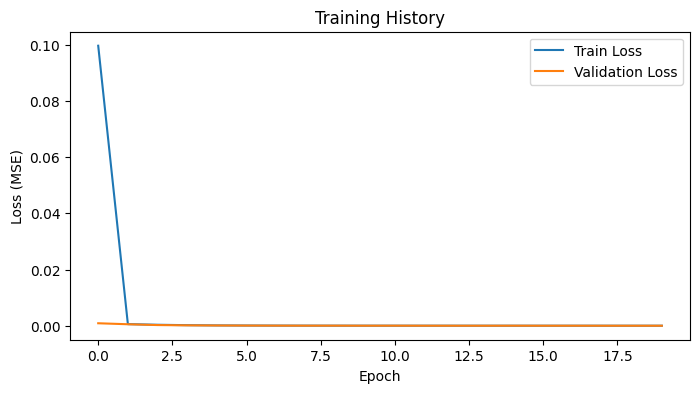

In [ ]:
# Train autoencoder
history = autoencoder.fit(
    X_train, Y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_val, Y_val)
)

# Plot training history
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Training History')
plt.legend()
plt.show()

# Test the Autoencoder

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


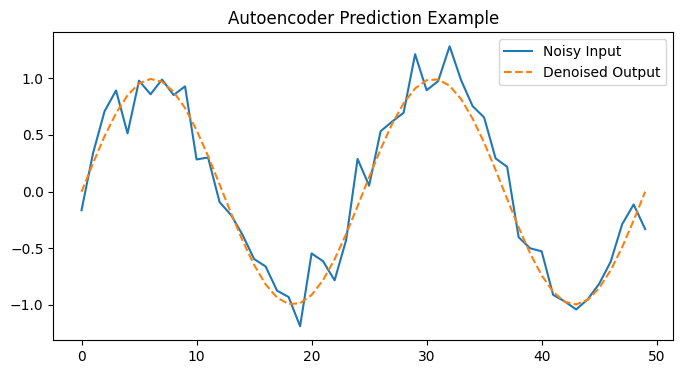

In [ ]:
# Evaluate model output (visual)
example_noisy = X_val[0:1]
predicted_clean = autoencoder.predict(example_noisy)

plt.figure(figsize=(8,4))
plt.plot(example_noisy[0], label="Noisy Input")
plt.plot(predicted_clean[0], label="Denoised Output", linestyle="dashed")
plt.legend()
plt.title("Autoencoder Prediction Example")
plt.show()

# Convert to TensorFlow Lite for ESP32

In [ ]:
# Convert to TFLite with Full INT8 Quantization
def representative_dataset():
    for _ in range(100):
        sample = np.random.rand(1, timesteps, 1).astype(np.float32)  # Random calibration samples
        yield [sample]

converter = tf.lite.TFLiteConverter.from_keras_model(autoencoder)
converter.optimizations = [tf.lite.Optimize.DEFAULT]  # Enable full model quantization
converter.representative_dataset = representative_dataset  # Required for INT8 quantization
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]  # Ensure INT8-only ops
converter.inference_input_type = tf.int8  # Convert input to INT8
converter.inference_output_type = tf.int8  # Convert output to INT8

tflite_model = converter.convert()

# Save the INT8 quantized model
with open("autoencoder_model_INT8.tflite", "wb") as f:
    f.write(tflite_model)

print("Model successfully converted to INT8 TensorFlow Lite format!")


Saved artifact at '/tmp/tmp4j_4zdap'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 50, 1), dtype=tf.float32, name='keras_tensor_116')
Output Type:
  TensorSpec(shape=(None, 50, 1), dtype=tf.float32, name=None)
Captures:
  140308200215120: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140308200218192: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140308200214352: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140308200216272: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140308196393424: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140308196394960: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140308196394768: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140308196395728: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140308196395152: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140308196396496: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140308196395

/usr/local/lib/python3.11/dist-packages/tensorflow/lite/python/convert.py:997: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
